In [1]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [11]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3, anomaly=0):
    dt = 1.0
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    X[:, 0] = mu  # начальные условия
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1]) * dt + sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t] = X[:, t-1] + dX
        timeline[t] = dt + timeline[t-1]
    if anomaly:
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += np.random.choice([1, -1]) * anomaly # аномалия +- anomaly сигм

    return X, timeline

Орнштейн-Уленбека, сигнатуры

In [50]:
def train_nn_window(model_params, window):    # Для линейной функции
    np.random.seed(400)
    torch.manual_seed(400)

    def calc_sig_window(window, path, timeline, dimension, level):
        mean_sig = np.zeros(iisignature.siglength(dimension, level))
        for i in range(int(len(path) / window)):
            last_border = (i + 1) * window
            if last_border > len(path):
                last_border = len(path)
            mean_sig += iisignature.sig(np.column_stack((timeline[i * window:last_border], path[i * window:last_border])), level)
        mean_sig /= int(len(path) / window)
        return mean_sig

    n_samples = model_params["n_samples"]
    n_steps = model_params["n_steps"]
    mu = model_params["mu"]
    theta = model_params["theta"]
    sigma = model_params["sigma"]
    anomaly_level = model_params["anomaly_level"]
    dimension = model_params["dimension"]
    level = model_params["level"]

    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), window, anomaly=False)
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), window, anomaly=5)
    
    signatures_no_anomaly = []
    for i in range(X_noanomaly.shape[0]):
        signature = calc_sig_window(window, X_noanomaly[i], timeline, dimension, level)
        signatures_no_anomaly.append(signature)
    signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)

    signatures_with_anomaly = []
    for i in range(X_anomaly.shape[0]):
        signature = calc_sig_window(window, X_anomaly[i], timeline, dimension, level)
        signatures_with_anomaly.append(signature)
    signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)

    y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
    y_anomaly = np.ones(signatures_with_anomaly.shape[0])
    X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    class ThreeLayerNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x

    input_size = 1 + iisignature.siglength(dimension, level)
    hidden_size = 64
    output_size = 1
    model = ThreeLayerNN(input_size, hidden_size, output_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    best_accuracy = 0
    best_epoch = 0
    loss_best_accuracy = 10**10
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Тестирование модели
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

            accuracy = 100 * correct / total
            if best_accuracy < accuracy:
                best_accuracy = accuracy
                best_epoch = epoch
                loss_best_accuracy = loss

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

    print(f"Лучшая точность: {best_accuracy:.2f}% на эпохе {best_epoch+1}")
    return best_accuracy


In [51]:
model_params = {
    "n_samples": 10000,
    "n_steps": 100,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}

Окно: 5
Epoch [1/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [2/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [3/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [6/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [7/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [8/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [9/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [10/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [11/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [13/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0000, Accuracy: 100.00%
Лучшая точность: 100.00% на эпохе 1
Окно: 10
Epoch [1/20], Lo

Epoch [11/20], Loss: 31.2500, Accuracy: 70.40%
Epoch [12/20], Loss: 34.3750, Accuracy: 70.40%
Epoch [13/20], Loss: 34.3750, Accuracy: 70.40%
Epoch [14/20], Loss: 28.1250, Accuracy: 70.40%
Epoch [15/20], Loss: 15.6250, Accuracy: 70.40%
Epoch [16/20], Loss: 31.2500, Accuracy: 70.40%
Epoch [17/20], Loss: 18.7500, Accuracy: 70.40%
Epoch [18/20], Loss: 46.8750, Accuracy: 70.40%
Epoch [19/20], Loss: 25.0000, Accuracy: 70.40%
Epoch [20/20], Loss: 37.5000, Accuracy: 70.40%
Лучшая точность: 70.40% на эпохе 1
Окно: 50
Epoch [1/20], Loss: 40.6250, Accuracy: 70.25%
Epoch [2/20], Loss: 21.8750, Accuracy: 70.25%
Epoch [3/20], Loss: 40.6250, Accuracy: 70.25%
Epoch [4/20], Loss: 28.1250, Accuracy: 70.25%
Epoch [5/20], Loss: 28.1250, Accuracy: 70.25%
Epoch [6/20], Loss: 21.8750, Accuracy: 70.25%
Epoch [7/20], Loss: 34.3750, Accuracy: 70.25%
Epoch [8/20], Loss: 28.1250, Accuracy: 70.25%
Epoch [9/20], Loss: 40.6250, Accuracy: 70.25%
Epoch [10/20], Loss: 43.7500, Accuracy: 70.25%
Epoch [11/20], Loss: 31.2

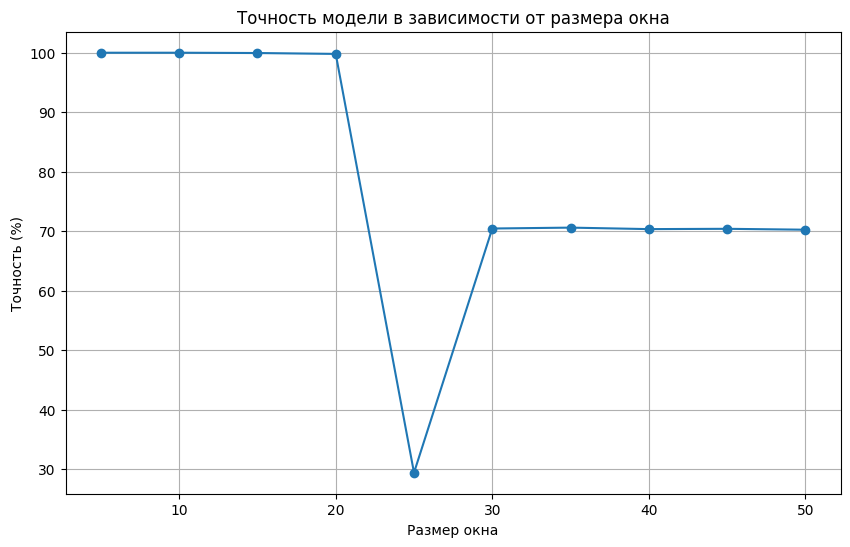

In [52]:
# Обучаем модель для разных размеров окон и строим график

window_sizes = range(5, 51, 5)
accuracies = []
import copy
for window in window_sizes:
    print(f"Окно: {window}")
    accuracy = train_nn_window(model_params, window)
    accuracies.append(accuracy)

# Построение графика

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

Орнштейн-Уленбека, без сигнатур

In [53]:
def train_nn_window(model_params, window):    # Для линейной функции
    np.random.seed(400)
    torch.manual_seed(400)

    def calc_sig_window(window, path, timeline, dimension, level):
        mean_sig = np.zeros(iisignature.siglength(dimension, level))
        for i in range(int(len(path) / window)):
            last_border = (i + 1) * window
            if last_border > len(path):
                last_border = len(path)
            mean_sig += iisignature.sig(np.column_stack((timeline[i * window:last_border], path[i * window:last_border])), level)
        mean_sig /= int(len(path) / window)
        return mean_sig

    n_samples = model_params["n_samples"]
    n_steps = model_params["n_steps"]
    mu = model_params["mu"]
    theta = model_params["theta"]
    sigma = model_params["sigma"]
    anomaly_level = model_params["anomaly_level"]
    dimension = model_params["dimension"]
    level = model_params["level"]

    X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), window, anomaly=False)
    X_anomaly, timeline = generate_ou_process(int(n_samples * 0.3), window, anomaly=5)
    
    y_noanomaly = np.zeros(X_noanomaly.shape[0])
    y_anomaly = np.ones(X_anomaly.shape[0])
    X = np.vstack((X_noanomaly, X_anomaly))
    y = np.hstack((y_noanomaly, y_anomaly))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    class ThreeLayerNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x

    input_size = window
    hidden_size = 64
    output_size = 1
    model = ThreeLayerNN(input_size, hidden_size, output_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    best_accuracy = 0
    best_epoch = 0
    loss_best_accuracy = 10**10
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Тестирование модели
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

            accuracy = 100 * correct / total
            if best_accuracy < accuracy:
                best_accuracy = accuracy
                best_epoch = epoch
                loss_best_accuracy = loss

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

    print(f"Лучшая точность: {best_accuracy:.2f}% на эпохе {best_epoch+1}")
    return best_accuracy


In [54]:
model_params = {
    "n_samples": 10000,
    "n_steps": 100,
    "mu": 0.0,
    "theta": 0.15,
    "sigma": 0.3,
    "anomaly_level": 5,
    "level": 7,
    "dimension": 2
}

Окно: 10
Epoch [1/20], Loss: 0.0047, Accuracy: 100.00%
Epoch [2/20], Loss: 0.0007, Accuracy: 100.00%
Epoch [3/20], Loss: 0.0006, Accuracy: 100.00%
Epoch [4/20], Loss: 0.0003, Accuracy: 100.00%
Epoch [5/20], Loss: 0.0002, Accuracy: 100.00%
Epoch [6/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [7/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [8/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [9/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [10/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [11/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [13/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0000, Accuracy: 100.00%
Лучшая точность: 100.00% на эпохе 1
Окно: 20
Epoch [1/20], L

Epoch [10/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [11/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0001, Accuracy: 99.95%
Epoch [13/20], Loss: 0.0001, Accuracy: 99.95%
Epoch [14/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0000, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0000, Accuracy: 100.00%
Лучшая точность: 100.00% на эпохе 7
Окно: 100
Epoch [1/20], Loss: 0.2584, Accuracy: 92.25%
Epoch [2/20], Loss: 0.0401, Accuracy: 99.40%
Epoch [3/20], Loss: 0.0202, Accuracy: 99.65%
Epoch [4/20], Loss: 0.0050, Accuracy: 99.85%
Epoch [5/20], Loss: 0.0013, Accuracy: 99.85%
Epoch [6/20], Loss: 0.0013, Accuracy: 99.95%
Epoch [7/20], Loss: 0.0004, Accuracy: 99.90%
Epoch [8/20], Loss: 0.0008, Accuracy: 99.95%
Epoch [9/20], Loss: 0.0004, Accuracy: 99.95%
Epoch [10/20], Loss: 0.0003, Accur

Epoch [1/20], Loss: 0.6450, Accuracy: 71.20%
Epoch [2/20], Loss: 0.3586, Accuracy: 86.45%
Epoch [3/20], Loss: 0.1864, Accuracy: 94.00%
Epoch [4/20], Loss: 0.0144, Accuracy: 95.95%
Epoch [5/20], Loss: 0.0147, Accuracy: 95.75%
Epoch [6/20], Loss: 0.0088, Accuracy: 97.60%
Epoch [7/20], Loss: 0.0126, Accuracy: 96.25%
Epoch [8/20], Loss: 0.0068, Accuracy: 97.35%
Epoch [9/20], Loss: 0.0023, Accuracy: 98.00%
Epoch [10/20], Loss: 0.0007, Accuracy: 97.30%
Epoch [11/20], Loss: 0.0003, Accuracy: 97.50%
Epoch [12/20], Loss: 0.0004, Accuracy: 97.35%
Epoch [13/20], Loss: 0.0002, Accuracy: 97.20%
Epoch [14/20], Loss: 0.0002, Accuracy: 97.35%
Epoch [15/20], Loss: 0.0001, Accuracy: 97.45%
Epoch [16/20], Loss: 0.0002, Accuracy: 97.40%
Epoch [17/20], Loss: 0.0002, Accuracy: 97.40%
Epoch [18/20], Loss: 0.0002, Accuracy: 97.35%
Epoch [19/20], Loss: 0.0001, Accuracy: 97.45%
Epoch [20/20], Loss: 0.0001, Accuracy: 97.45%
Лучшая точность: 98.00% на эпохе 9
Окно: 190
Epoch [1/20], Loss: 0.7001, Accuracy: 70.30%

Epoch [13/20], Loss: 0.0028, Accuracy: 87.70%
Epoch [14/20], Loss: 0.0018, Accuracy: 87.75%
Epoch [15/20], Loss: 0.0012, Accuracy: 88.25%
Epoch [16/20], Loss: 0.0014, Accuracy: 87.80%
Epoch [17/20], Loss: 0.0006, Accuracy: 87.80%
Epoch [18/20], Loss: 0.0004, Accuracy: 87.60%
Epoch [19/20], Loss: 0.0007, Accuracy: 88.05%
Epoch [20/20], Loss: 0.0003, Accuracy: 87.75%
Лучшая точность: 88.25% на эпохе 15
Окно: 270
Epoch [1/20], Loss: 0.6968, Accuracy: 70.00%
Epoch [2/20], Loss: 0.6467, Accuracy: 70.85%
Epoch [3/20], Loss: 0.5565, Accuracy: 72.05%
Epoch [4/20], Loss: 0.2952, Accuracy: 75.10%
Epoch [5/20], Loss: 0.2819, Accuracy: 77.60%
Epoch [6/20], Loss: 0.3291, Accuracy: 80.55%
Epoch [7/20], Loss: 0.2445, Accuracy: 81.95%
Epoch [8/20], Loss: 0.2147, Accuracy: 82.65%
Epoch [9/20], Loss: 0.0589, Accuracy: 82.40%
Epoch [10/20], Loss: 0.1738, Accuracy: 84.00%
Epoch [11/20], Loss: 0.0100, Accuracy: 84.50%
Epoch [12/20], Loss: 0.0620, Accuracy: 82.85%
Epoch [13/20], Loss: 0.0726, Accuracy: 83.7

Epoch [5/20], Loss: 0.3929, Accuracy: 70.50%
Epoch [6/20], Loss: 0.5524, Accuracy: 70.75%
Epoch [7/20], Loss: 0.2380, Accuracy: 72.30%
Epoch [8/20], Loss: 0.1716, Accuracy: 72.90%
Epoch [9/20], Loss: 0.2123, Accuracy: 72.80%
Epoch [10/20], Loss: 0.1373, Accuracy: 73.90%
Epoch [11/20], Loss: 0.0469, Accuracy: 73.45%
Epoch [12/20], Loss: 0.1382, Accuracy: 73.95%
Epoch [13/20], Loss: 0.0482, Accuracy: 73.50%
Epoch [14/20], Loss: 0.0052, Accuracy: 74.05%
Epoch [15/20], Loss: 0.0046, Accuracy: 73.60%
Epoch [16/20], Loss: 0.0804, Accuracy: 73.60%
Epoch [17/20], Loss: 0.0104, Accuracy: 73.70%
Epoch [18/20], Loss: 0.0583, Accuracy: 74.35%
Epoch [19/20], Loss: 0.0474, Accuracy: 75.45%
Epoch [20/20], Loss: 0.0192, Accuracy: 74.90%
Лучшая точность: 75.45% на эпохе 19
Окно: 360
Epoch [1/20], Loss: 0.5491, Accuracy: 70.00%
Epoch [2/20], Loss: 0.6124, Accuracy: 70.00%
Epoch [3/20], Loss: 0.5540, Accuracy: 69.15%
Epoch [4/20], Loss: 0.4980, Accuracy: 68.45%
Epoch [5/20], Loss: 0.3957, Accuracy: 68.50

Epoch [17/20], Loss: 0.0036, Accuracy: 66.45%
Epoch [18/20], Loss: 0.0025, Accuracy: 66.10%
Epoch [19/20], Loss: 0.0017, Accuracy: 66.35%
Epoch [20/20], Loss: 0.0023, Accuracy: 66.15%
Лучшая точность: 70.00% на эпохе 1
Окно: 440
Epoch [1/20], Loss: 0.7167, Accuracy: 70.00%
Epoch [2/20], Loss: 0.6017, Accuracy: 70.00%
Epoch [3/20], Loss: 0.4283, Accuracy: 69.85%
Epoch [4/20], Loss: 0.4517, Accuracy: 67.15%
Epoch [5/20], Loss: 0.4601, Accuracy: 64.75%
Epoch [6/20], Loss: 0.3436, Accuracy: 65.95%
Epoch [7/20], Loss: 0.4447, Accuracy: 62.05%
Epoch [8/20], Loss: 0.3228, Accuracy: 63.80%
Epoch [9/20], Loss: 0.2424, Accuracy: 62.85%
Epoch [10/20], Loss: 0.1802, Accuracy: 66.05%
Epoch [11/20], Loss: 0.0856, Accuracy: 63.30%
Epoch [12/20], Loss: 0.0771, Accuracy: 63.20%
Epoch [13/20], Loss: 0.0427, Accuracy: 63.70%
Epoch [14/20], Loss: 0.0135, Accuracy: 63.50%
Epoch [15/20], Loss: 0.0949, Accuracy: 63.90%
Epoch [16/20], Loss: 0.0170, Accuracy: 63.90%
Epoch [17/20], Loss: 0.0046, Accuracy: 64.80

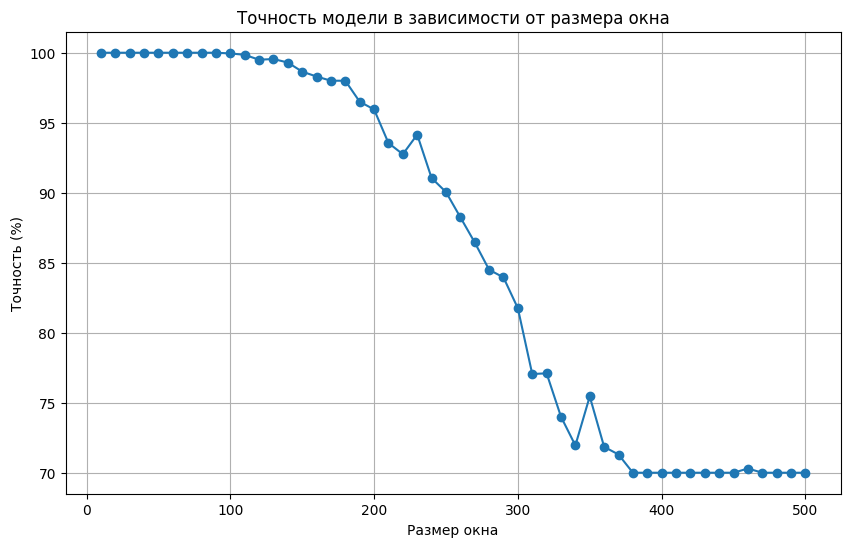

In [55]:
# Обучаем модель для разных размеров окон и строим график

window_sizes = range(10, 501, 10)
accuracies = []
import copy
for window in window_sizes:
    print(f"Окно: {window}")
    accuracy = train_nn_window(model_params, window)
    accuracies.append(accuracy)

# Построение графика

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.title("Точность модели в зависимости от размера окна")
plt.xlabel("Размер окна")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()